# This is how I'll want to use the inversion package on simple problems

In [1]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
from fatiando import utils
import cPickle as pickle
from inversion import LinearMisfit

In [2]:
class Regression(LinearMisfit):
    def __init__(self, degree):
        # The solver is now independent of the data.
        super().__init__(nparams=(degree + 1))
        self.degree = degree
        
    def predict(self, x, p=None):
        # Make ommiting p option explicit
        # People from workshop said it was strange that it could be ommited even though they didn't code it that way
        if p is None:
            p = self.p_
        return sum(p[i]*x**i for i in reversed(range(self.nparams)))
        
    def jacobian(self, x, p):
        # Last argument is always p
        # Can have multiple args before it
        A = np.empty((x.size, self.nparams))
        for i in reversed(range(self.nparams)):
            A[:, i] = x**i
        return A
    
    def fit(self, x, y, **kwargs):
        """
        Docstrings!
        """
        return super().fit(x, y, **kwargs)
    
    def fmt_estimate(self, p):
        eq = ' + '.join(['{:g}x^{}'.format(p[i], i) for i in reversed(range(self.nparams))])
        return eq

# Test on data

In [3]:
coefs = a, b, c, d = 0.5, 0, 1, 1000
def make_data(coefs, n):
    x = np.linspace(-100, 100, n)
    y = a*x**3 + b*x**2 + c*x + d
    yo = utils.contaminate(y, 0.1, percent=True, seed=0)
    return x, yo
x, yo = make_data(coefs, 200)

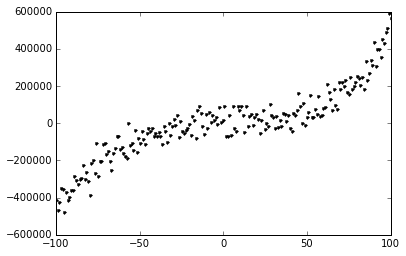

In [4]:
plt.plot(x, yo, '.k')

In [5]:
reg = Regression(3)
reg.fit(x, yo).p_

array([ -4.47615886e+02,   2.74029898e+02,   4.29963524e-01,
         4.47223384e-01])

In [6]:
reg.fmt_estimate(coefs[::-1])

'0.5x^3 + 0x^2 + 1x^1 + 1000x^0'

In [7]:
reg.estimate_
# Should print the equation

'0.447223x^3 + 0.429964x^2 + 274.03x^1 + -447.616x^0'

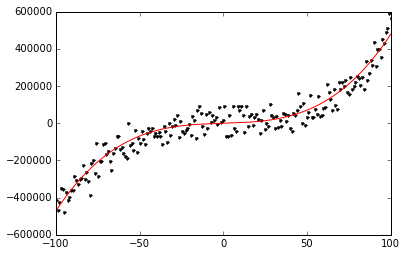

In [8]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

In [9]:
# Caching still works
reg.predict(x) is reg.predict(x)

True

In [10]:
# But the Jacobian is still cached
reg.jacobian(x=x, p=None) is reg.jacobian(x=x, p=None)

True

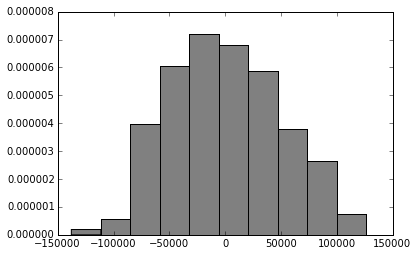

In [11]:
# No more residuals, since reg doesn't store the data
_ = plt.hist(yo - reg.predict(x), 10, normed=True, color='grey')

In [12]:
# Can be pickled for use in parallel
reg = pickle.loads(pickle.dumps(reg))

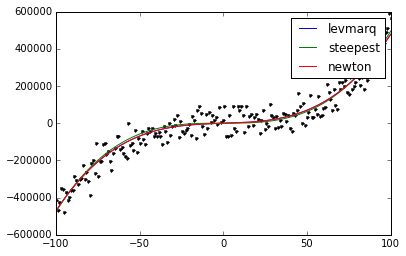

In [13]:
# Config still works
plt.plot(x, yo, '.k')
for meth in ['levmarq', 'steepest', 'newton']:
    reg = Regression(3)
    reg.config(method=meth, initial=np.ones(reg.nparams)).fit(x, yo).estimate_
    plt.plot(x, reg.predict(x), '-', label=meth)
plt.legend()

In [14]:
# Config still works
reg.config(method='acor', bounds=[0, 10000, 0, 10, 0, 1, 0, 10]).fit(x, yo).estimate_

'0.483822x^3 + 0.356101x^2 + 10x^1 + 2.53612e-10x^0'

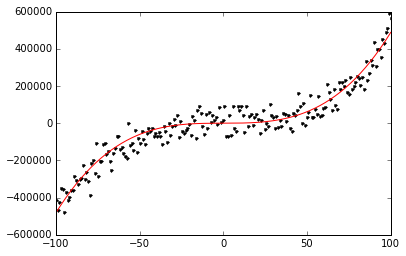

In [15]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

Can use methods from [scipy.optimize.minimize](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

0.447493x^3 + 0.255776x^2 + 272.082x^1 + 608.253x^0


/home/leo/bin/anaconda/envs/fatiando-dev/lib/python2.7/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/home/leo/bin/anaconda/envs/fatiando-dev/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)


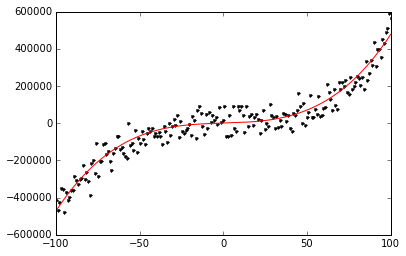

In [16]:
print(reg.config('Nelder-Mead', x0=np.ones(reg.nparams)).fit(x, yo).estimate_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# Using cross-validation

In [17]:
rand = np.random.RandomState(42)
whole = rand.permutation(x.size)
divide = int(0.65*x.size)
train, test = whole[:divide], whole[divide:]

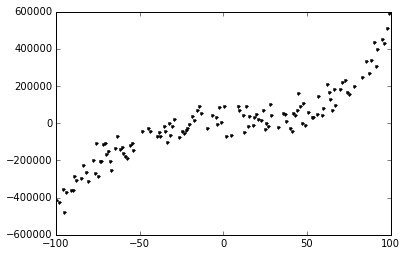

In [18]:
plt.plot(x[train], yo[train], '.k')

In [19]:
degrees = list(range(1, 20))
scores = [Regression(i).fit(x[train], yo[train]).score(x[test], yo[test])
          for i in degrees]
best = degrees[np.argmin(scores)]
best

8

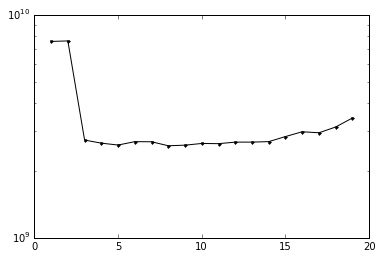

In [20]:
plt.plot(degrees, scores, '.-k')
plt.yscale('log')

In [21]:
reg = Regression(best).fit(x, yo)
reg.estimate_

'1.8635e-10x^8 + 3.54139e-09x^7 + -3.438e-06x^6 + -4.23827e-05x^5 + 0.021224x^4 + 0.539743x^3 + -49.1589x^2 + 350.096x^1 + 24056.7x^0'

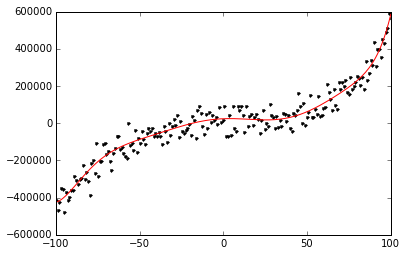

In [22]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# Re-weighted

In [23]:
yo2 = np.copy(yo)
yo2[rand.choice(yo.size, size=20)] += 1e6

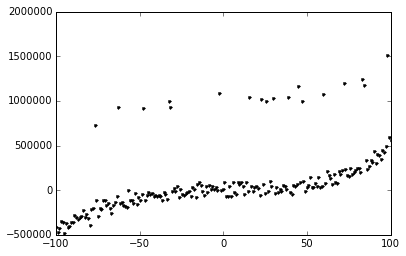

In [24]:
plt.plot(x, yo2, '.k')

In [25]:
reg = Regression(3).fit(x, yo2)
reg.estimate_

'0.425958x^3 + -2.96748x^2 + 946.185x^1 + 100991x^0'

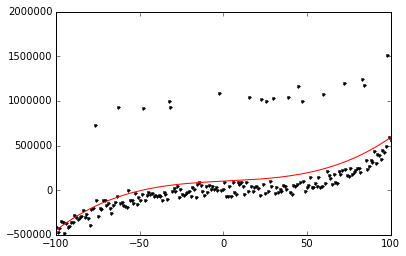

In [26]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg.predict(x), '-r')

In [27]:
reg2 = Regression(3).fit(x, yo2)
r = np.abs(yo2 - reg2.predict(x))
reg2.fit(x, yo2, weights=1/r).estimate_

'0.455232x^3 + -0.592576x^2 + 422.617x^1 + 47305x^0'

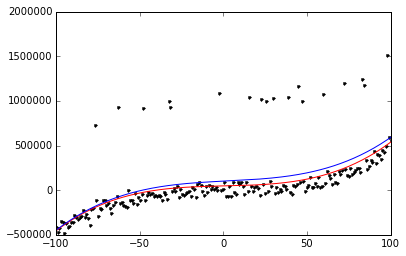

In [28]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg2.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

In [29]:
reg3 = Regression(3).fit_reweighted(x, yo2, iterations=100)
reg3.estimate_

'0.434213x^3 + 0.0404101x^2 + 411.187x^1 + 8416.46x^0'

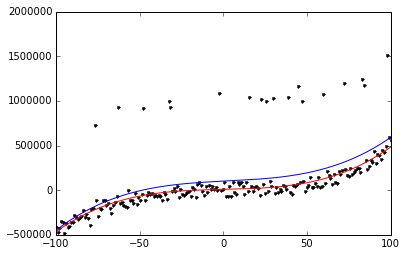

In [30]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg3.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

# Multiple data sets

In [42]:
x2 = np.linspace(110, 200, 200)
y2 = 0.05*(x2 - 50)**3 + 1000
yo2 = utils.contaminate(y2, 0.1, percent=True, seed=0)

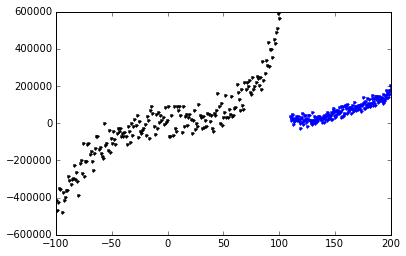

In [43]:
plt.plot(x, yo, '.k')
plt.plot(x2, yo2, '.b')

0.447223x^3 + 0.429963x^2 + 274.03x^1 + -447.614x^0


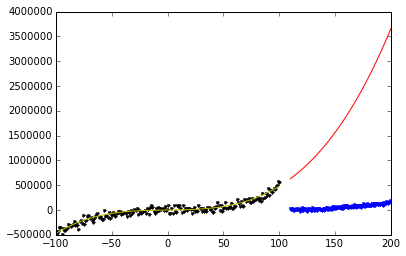

In [44]:
# If there are many misfits (have fit method), will split the arguments between them.
mul = (Regression(3) + 1e-10*Regression(3)).fit(x, yo, x2, yo2)
print(mul.estimate_)

plt.plot(x, yo, '.k')
plt.plot(x2, yo2, '.b')
plt.plot(x, mul[0].predict(x), '-y')
plt.plot(x2, mul[1].predict(x2), '-r')

-0.146191x^3 + 84.4479x^2 + -13782.9x^1 + 710272x^0


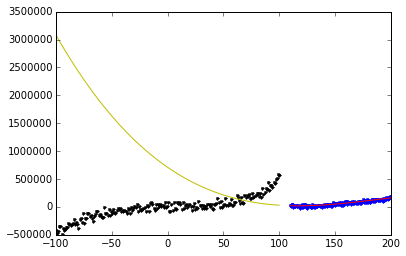

In [45]:
# If there are many misfits (have fit method), will split the arguments between them.
mul = (1e-10*Regression(3) + Regression(3)).fit(x, yo, x2, yo2)
print(mul.estimate_)

plt.plot(x, yo, '.k')
plt.plot(x2, yo2, '.b')
plt.plot(x, mul[0].predict(x), '-y')
plt.plot(x2, mul[1].predict(x2), '-r')